In [2]:
# !pip install dask[dataframe]
# !sudo apt-get install graphviz graphviz-dev
# !sudo apt-get install build-essential
# !pip install pygraphviz
# !pip install dowhy==0.8
# !pip install econml

In [3]:
from copy import deepcopy

import numpy as np
import pandas as pd
from scipy import stats

from sklearn.metrics import mean_absolute_percentage_error

import dowhy
from dowhy import CausalModel

from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from lightgbm import LGBMRegressor, LGBMClassifier

import networkx as nx

from tqdm import tqdm

import matplotlib.pyplot as plt

import graphviz
import warnings

warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
COLORS = [
    '#00B0F0',
    '#FF0000',
    '#B0F000'
]
def plot_effect(effect_true, effect_pred, figsize=(10, 7), ylim=(5000, 22000)):
    plt.figure(figsize=figsize)
    plt.scatter(effect_true, effect_pred, color=COLORS[0])
    plt.plot(np.sort(effect_true), np.sort(effect_true), color=COLORS[1], alpha=.7, label='Perfect model')
    plt.xlabel('$True\ effect$', fontsize=14, alpha=.5)
    plt.ylabel('$Predicted\ effect$', fontsize=14, alpha=.5)
    plt.ylim(ylim[0], ylim[1])
    plt.legend()
    plt.show()

# Read Data

In [5]:
# Train set
earnings_interaction_train = pd.read_csv('./data/ml_earnings_interaction_train.csv')

# Test set
earnings_interaction_test = pd.read_csv('./data/ml_earnings_interaction_test.csv')

In [6]:
earnings_interaction_train.shape, earnings_interaction_test.shape

((5000, 4), (100, 4))

In [7]:
# Train
earnings_interaction_train.head()

,age,python_proficiency,took_a_course,earnings
0,23,0.632318,True,139267.0
1,20,0.602551,False,115569.0
2,21,0.518225,False,119142.0
3,25,0.945161,False,130291.0
4,30,0.636251,True,164209.0


In [8]:
# Test
earnings_interaction_test.head()

,age,python_proficiency,took_a_course,true_effect
0,30,0.223877,True,11120.0
1,23,0.394152,True,11970.0
2,37,0.214638,True,11073.0
3,21,0.869069,True,14345.0
4,41,0.833934,True,14169.0


# Define the graph

In [9]:
nodes = ['took_a_course', 'python_proficiency', 'earnings', 'age']
edges = [
    ('took_a_course', 'earnings'),
    ('age', 'took_a_course'),
    ('age', 'earnings'),
    ('python_proficiency', 'earnings')
]

# Generate the GML graph
gml_string = 'graph [directed 1\n'

for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'

for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target "{edge[1]}"]\n'

gml_string += ']'

In [10]:
# Instantiate the CausalModel
model = CausalModel(
    data=earnings_interaction_train,
    treatment='took_a_course',
    outcome='earnings',
    effect_modifiers='python_proficiency',
    graph=gml_string
)

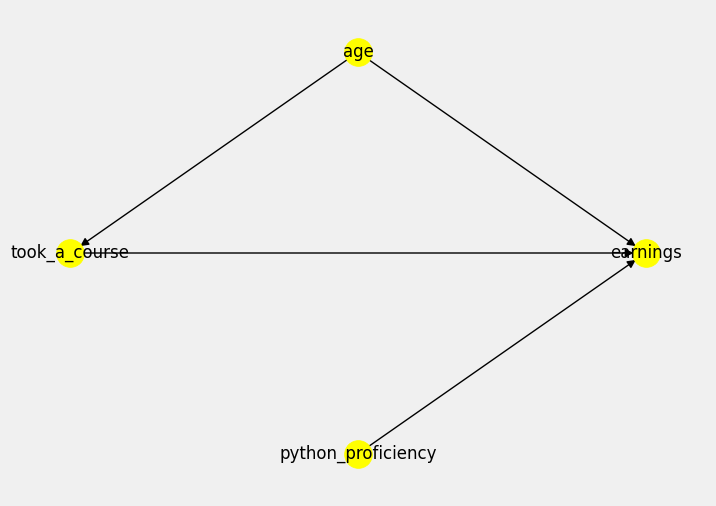

In [11]:
model.view_model()

In [12]:
# Get the estimand
estimand = model.identify_effect()

print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
       d                         
────────────────(E[earnings|age])
d[took_a_course]                 
Estimand assumption 1, Unconfoundedness: If U→{took_a_course} and U→earnings then P(earnings|took_a_course,age,U) = P(earnings|took_a_course,age)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



# Estimate Effect | S-Learner

In [ ]:
# Get estimate (S-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.SLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'overall_model': LGBMRegressor(n_estimators=500, max_depth=10)
        },
        'fit_params': {}
    })

In [14]:
# cate estimates
estimate.cate_estimates

array([12656.36520543, 14362.76895365, 11965.20495174, ...,
       13812.20928872, 12930.34061036, 13863.00226379])

In [15]:
# cate estimates mean
estimate.cate_estimates.mean()

12547.068205674783

### Refute

In [ ]:
refutation = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='random_common_cause'
)

In [17]:
print(refutation)

Refute: Add a random common cause
Estimated effect:12547.068205674783
New effect:12547.277272934201
p value:0.98



In [ ]:
refutation = model.refute_estimate(
    estimand=estimand,
    estimate=estimate,
    method_name='placebo_treatment_refuter')

In [19]:
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:12547.068205674783
New effect:-23.154108668414956
p value:0.72



### Test Data Prediction

In [20]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [21]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.050273209257800315

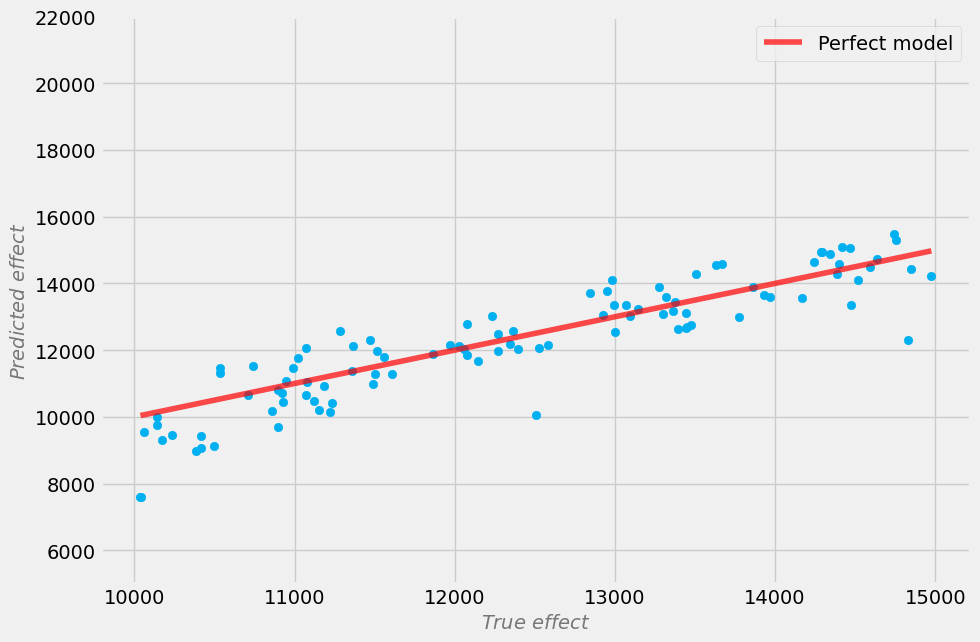

In [22]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

# T Learner

In [ ]:
# Get estimate (T-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.TLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(n_estimators=200, max_depth=10),
                LGBMRegressor(n_estimators=200, max_depth=10)
            ]
        },
        'fit_params': {}
    })

In [24]:
estimate.cate_estimates.mean()

12512.558912135146

### Test Data Prediction

In [25]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [26]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.0813365927834967

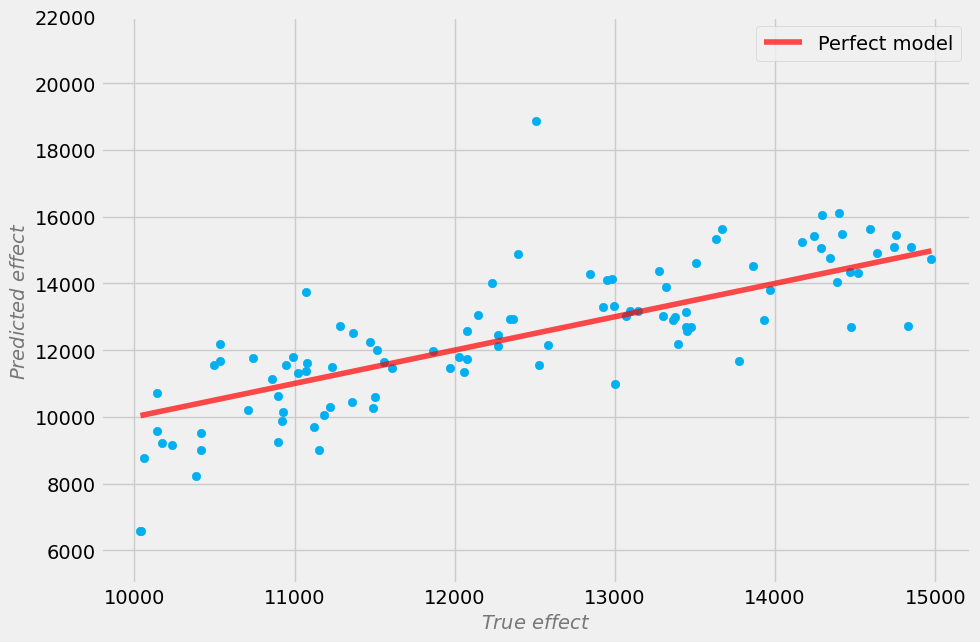

In [27]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)

# X-Learner

## Steps for `XLearner`

### Split Data into Treatment and Control Groups
Separate your dataset into two groups: one for the treated units and one for the control units.

### Train Initial Models
Train two models: one on the control group to predict the outcome for the control units, and another on the treatment group to predict the outcome for the treated units.
These models are used to estimate the potential outcomes for both treated and control units.

### Estimate Potential Outcomes
Use the trained models to predict the potential outcomes for all units in the dataset.
For each unit, predict the outcome if it were treated and if it were not treated.

### Calculate Pseudo-Outcomes
Calculate the pseudo-outcomes for the control and treatment groups.
- For the control group, the pseudo-outcome is the difference between the observed outcome and the predicted outcome if treated.
- For the treatment group, the pseudo-outcome is the difference between the observed outcome and the predicted outcome if not treated.

### Train CATE Models
Train two new models to predict the Conditional Average Treatment Effect (CATE) using the pseudo-outcomes.
- One model is trained on the control group pseudo-outcomes.
- The other model is trained on the treatment group pseudo-outcomes.

### Estimate CATE
Use the trained CATE models to estimate the treatment effect for each unit in the dataset.
Combine the estimates from the two CATE models to get the final treatment effect estimate for each unit.

### Aggregate Treatment Effects
Aggregate the individual treatment effects to get the overall Average Treatment Effect (ATE) or other relevant metrics.


In [ ]:
# Get estimate (X-Learner)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.metalearners.XLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'models': [
                LGBMRegressor(n_estimators=50, max_depth=10),
                LGBMRegressor(n_estimators=50, max_depth=10)
            ],
            'cate_models': [
                LGBMRegressor(n_estimators=50, max_depth=10),
                LGBMRegressor(n_estimators=50, max_depth=10)
            ]
        },
        'fit_params': {},
    })

In [29]:
estimate.cate_estimates.mean()

12564.919935370663

### Predict on Test Data

In [30]:
# Compute predictions
effect_pred = model.causal_estimator.effect(earnings_interaction_test.drop(['true_effect', 'took_a_course'], axis=1))

# Get the true effect
effect_true = earnings_interaction_test['true_effect'].values

In [31]:
# Compute the error
mean_absolute_percentage_error(effect_true, effect_pred)

0.03632496699577798

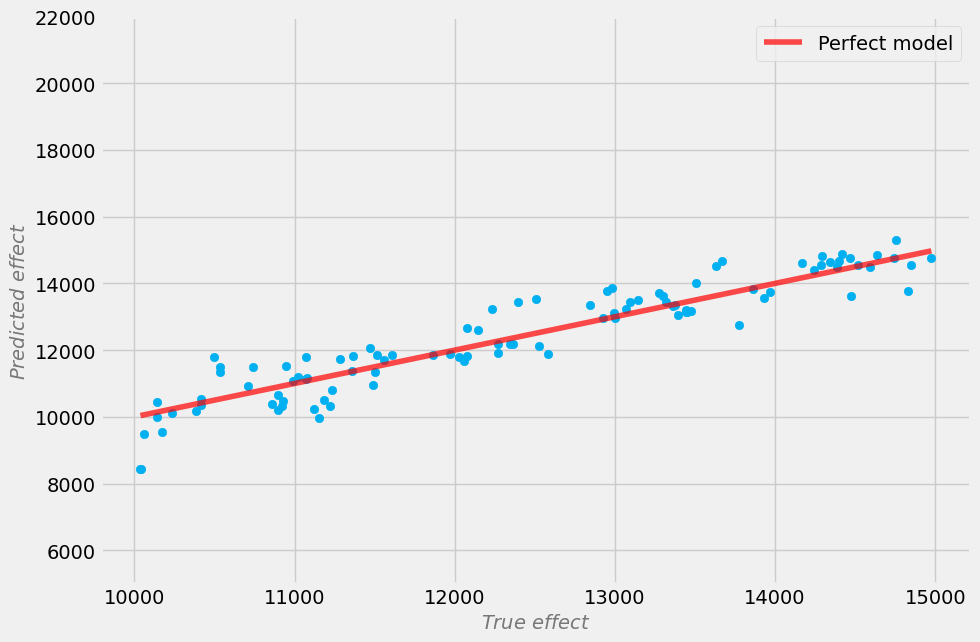

In [32]:
plot_effect(
    effect_true=effect_true,
    effect_pred=effect_pred,
)